Notebook to explore the random Embed trained at p =0.01 (Potentially the true computation in superposition case)

In [1]:
# Set up notebook

"""Import necessary packages"""

%load_ext autoreload
%autoreload 2

import os
from dataclasses import dataclass, field
from typing import Callable, List, Optional, Tuple, Union

import matplotlib as mpl
import numpy as np
import pandas as pd
import torch as t
import matplotlib.pyplot as plt

from einops import asnumpy, einsum, rearrange, reduce, repeat, pack, parse_shape, unpack
from einops.layers.torch import Rearrange, Reduce
from jaxtyping import Float, Int
from matplotlib import pyplot as plt
from plotly import express as px
from plotly import graph_objects as go
from plotly import io as pio
from rich import print as rprint
import seaborn as sns
from torch import nn, optim, Tensor
from torch.nn import functional as F
from tqdm.notebook import tqdm

from toy_cis.models import CisConfig, Cis
from toy_cis.plot import plot_loss_across_sparsities, plot_input_output_response, plot_phase_diagram_polysem
from toy_cis.plot import plot_weight_bars, plot_phase_diagram, plot_phase_diagram_training
from toy_cis.util import threshold_matrix, in_out_response, performance_across_sparsities

"""Set KMP_DUPLICATE_LIB_OK=TRUE to avoid MKL errors when plotting with mpl"""

os.environ["KMP_DUPLICATE_LIB_OK"] = "True"
plt.rcParams.update({"font.size": 16})

"""Set torch device."""

device = t.device("cuda" if t.cuda.is_available() else "cpu")
# device = t.device("cpu")  # small toy models have lower loss and are faster via cpu
device_name = t.cuda.get_device_name(0) if t.cuda.is_available() else "cpu"
print(f"{device_name=}")

device_name='NVIDIA A40'


In [2]:
"""ReLU + x model with Random embedding"""
layer_act_fns = [t.relu, lambda x: x]

reluPlusX_res_embed_cfg = CisConfig(
    name = "ReluPlusX_WithEmbedding",
    n_instances=1,
    n_feat=100,
    n_hidden=50,
    act_fn=layer_act_fns,
    b1=None,
    b2=None,
    skip_cnx=True,
    We_and_Wu=True,
    We_dim=1000,
)

In [3]:
# Choose a model to train and explore characteristics
"""Select the model configuration"""
model_cfg = reluPlusX_res_embed_cfg

"""Select the feature probability of the training input."""
feat_sparsity = 0.99

In [4]:
# Train model

"""Training hyperparameters"""
feat_prob = 1 - feat_sparsity
batch_sz = 2048
feat_importance = 1
lr = 3e-3
n_steps = 10000
logging_freq = n_steps // 10

model = Cis(model_cfg, device=device)

losses = model.train_reluPlusX(
        batch_sz,
        feat_sparsity,
        feat_importance,
        n_steps,
        lr, 
        logging_freq, 
)
display(losses)

Training:   0%|          | 0/10000 [00:00<?, ?it/s]

[0.001772225252352655,
 0.0008133530500344932,
 0.0009149428806267679,
 0.0007970283622853458,
 0.0008385675027966499,
 0.0008353249286301434,
 0.0008636841084808111,
 0.0008018938824534416,
 0.0008579242858104408,
 0.0008704820647835732,
 0.0008092190255410969]

X.shape =  torch.Size([100, 100, 100])
Y.shape =  torch.Size([100, 100, 100])


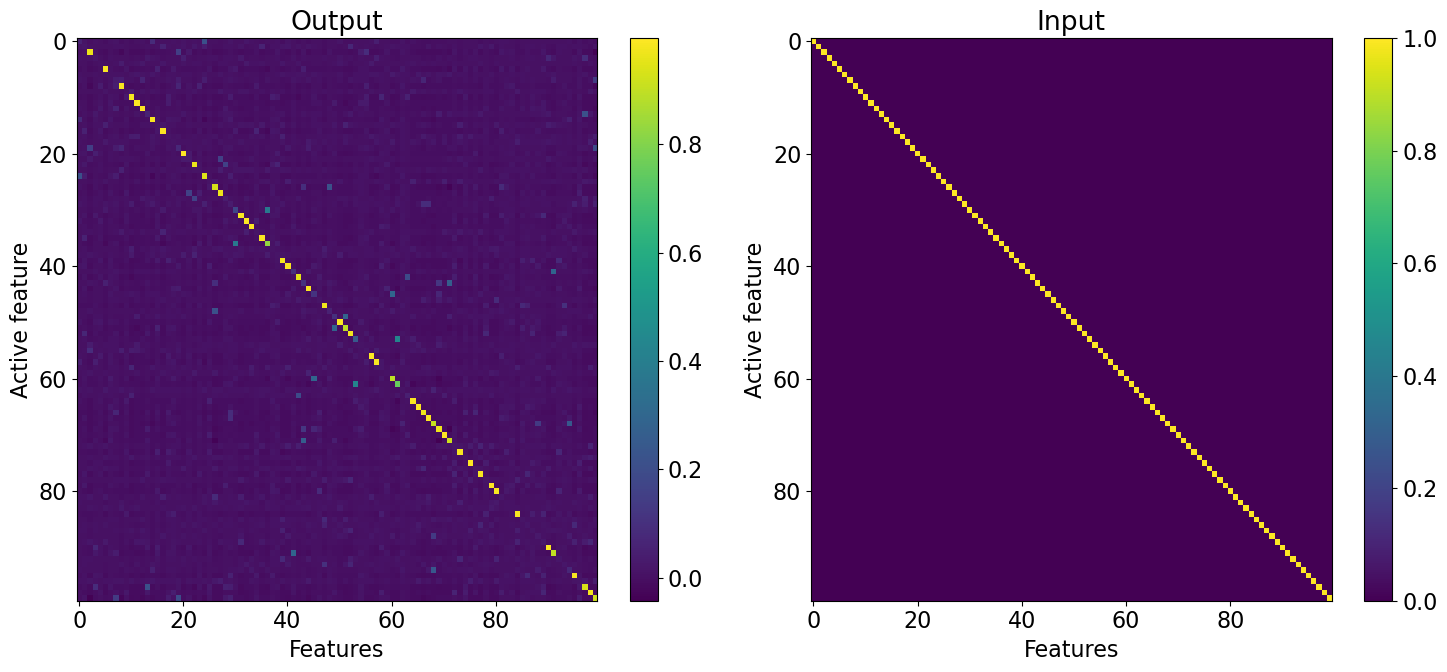

[[ 1.05979919e+00  1.28443101e-02  1.82779436e-03 ... -3.90794920e-03
   5.08303009e-03 -1.80041976e-03]
 [ 1.30889574e-02  1.02046096e+00  5.60130691e-03 ...  4.18563979e-03
  -3.01967817e-03  1.32393092e-02]
 [ 2.53152987e-03  6.11313479e-03  1.96289432e+00 ... -9.02455579e-03
  -7.28279771e-03 -3.72877344e-02]
 ...
 [-3.42971948e-03  5.06640226e-03 -7.65359402e-03 ...  1.93110693e+00
  -1.35613373e-02 -1.10782273e-02]
 [ 5.44299977e-03 -2.67315772e-03 -7.19550671e-03 ... -1.34092541e-02
   1.98102272e+00 -9.11800563e-03]
 [-9.60545964e-04  1.32927503e-02 -3.54086719e-02 ... -1.06182005e-02
  -8.75010714e-03  1.92540491e+00]]


In [5]:
"""Plot spectrum output plots"""

vals = t.linspace(-1, 1, 100, device=device)  # input values
active_feat_value_idx = 99

n_feat, n_vals = model.cfg.n_feat, len(vals)
# input `X` will be: active_feature_idx X values X full_feature_vector
X = t.zeros(n_feat, n_vals, n_feat, device=device)
feat_idx = t.arange(n_feat, device=device).unsqueeze(1).expand(n_feat, n_vals)
val_idx = t.arange(n_vals, device=device).unsqueeze(0).expand(n_feat, n_vals)
X[feat_idx, val_idx, feat_idx] = vals.unsqueeze(0).expand(n_feat, n_vals)
# reshape for batch input
X = rearrange(X, "active_feat val feat_vec -> (active_feat val) 1 feat_vec")
Y = model.forward(X)
    # reshape for plotting by feature
Y = rearrange(
   Y, 
   "(active_feat val) 1 feat_vec -> active_feat val feat_vec",
    active_feat=n_feat, 
   val=n_vals
)
X = rearrange(X, 
   "(active_feat val) 1 feat_vec -> active_feat val feat_vec",
    active_feat=n_feat, 
   val=n_vals)
print("X.shape = ", X.shape)
print("Y.shape = ", Y.shape)
output= Y[:,active_feat_value_idx,:].cpu().detach().numpy()
input = X[:,active_feat_value_idx,:].cpu().detach().numpy()

fig,axs = plt.subplots(1, 2, figsize=(15, 7))
im0 = axs[0].imshow(output-input, aspect='auto', cmap='viridis')
fig.colorbar(im0, ax=axs[0])
axs[0].set_title("Output")
axs[0].set_xlabel("Features")
axs[0].set_ylabel("Active feature")

im1 = axs[1].imshow(input, aspect='auto', cmap='viridis')
fig.colorbar(im1, ax=axs[1])
axs[1].set_title("Input")
axs[1].set_xlabel("Features")
axs[1].set_ylabel("Active feature")
#fig.title(f"{model.cfg.name} trained at featProb = {feat_prob:.2f}:\n output heatmap")
plt.tight_layout()
filename = f"/workspace/{model.cfg.name}_S{feat_prob:.2f}_output_heatmap.png" 
plt.savefig(filename, dpi=300)
plt.show()

print(Y[:,active_feat_value_idx,:].cpu().detach().numpy())

Testing over sparsities:   0%|          | 0/28 [00:00<?, ?it/s]

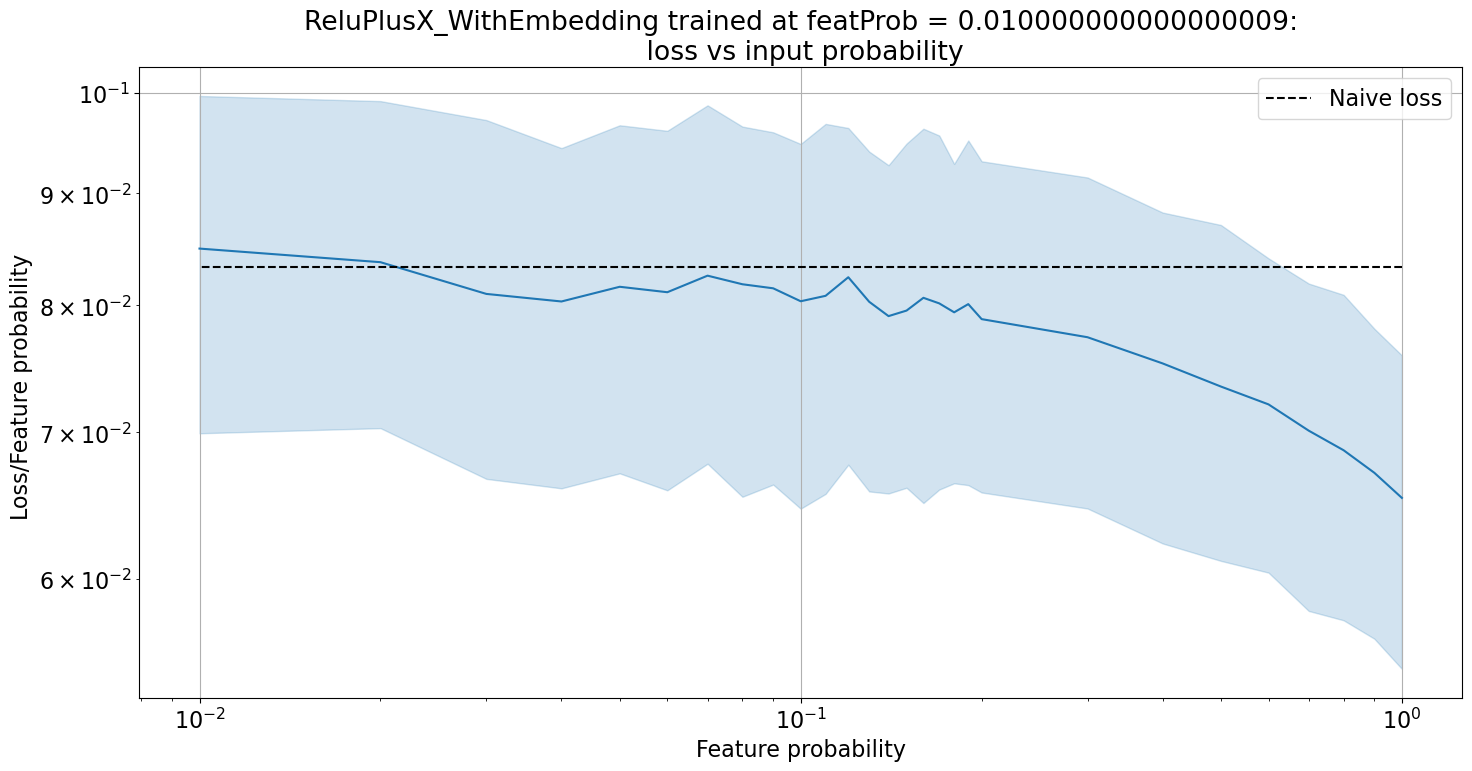

In [6]:
"""Compute and plot the model's performance across sparsities."""

sparsity_low = np.round(np.linspace(0.0,0.8,9),2)
sparsity_high = np.round(np.linspace(0.8,0.99,20),2)
sparsities = np.unique(np.concatenate((sparsity_low,sparsity_high)))
batch_sz = 256
feat_importance = 1

loss_data = performance_across_sparsities(sparsities, model)

"""Plot performance across different input sparsities"""
fig = plot_loss_across_sparsities(loss_data, sparsities, model.cfg.name, feat_sparsity)

# save figure and show
filename = f"/workspace/{model.cfg.name}_S{feat_prob:.2f}_loss_plot.png" 
plt.savefig(filename, dpi=300)
plt.show()

torch.Size([100, 100])


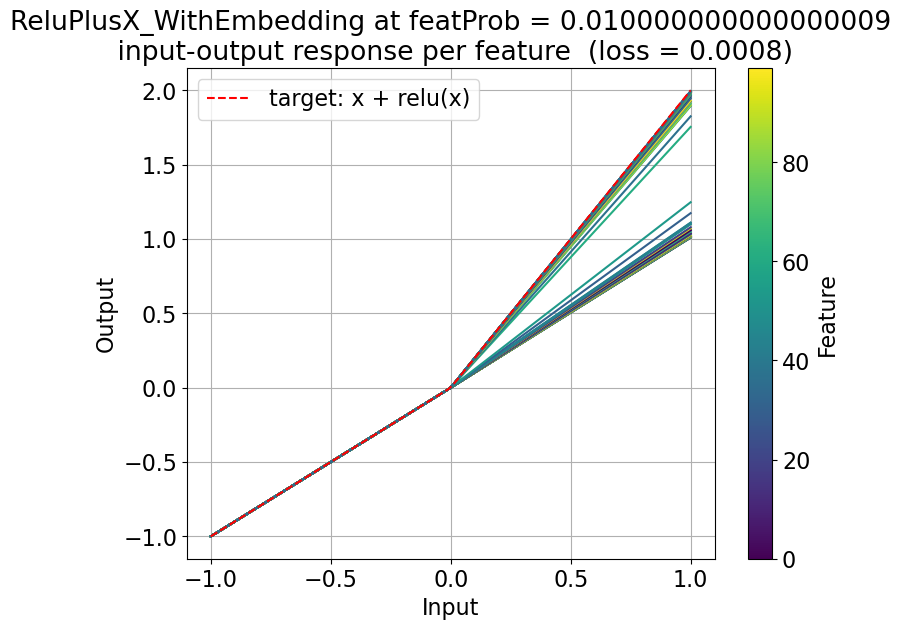

In [7]:
"""Compute and plot input-output response profile."""

vals = t.linspace(-1, 1, 100, device=device)  # input values
Y = in_out_response(model, vals, device)
print(Y.shape)
fig = plot_input_output_response(Y, vals, model.cfg.name, feat_prob, losses)

# save figure and show
filename = f"/workspace/{model.cfg.name}_S{feat_prob:.2f}_input_output_response.png" 
plt.savefig(filename, dpi=300)
plt.show()

W.shape=torch.Size([100, 50])


<function matplotlib.pyplot.show(close=None, block=None)>

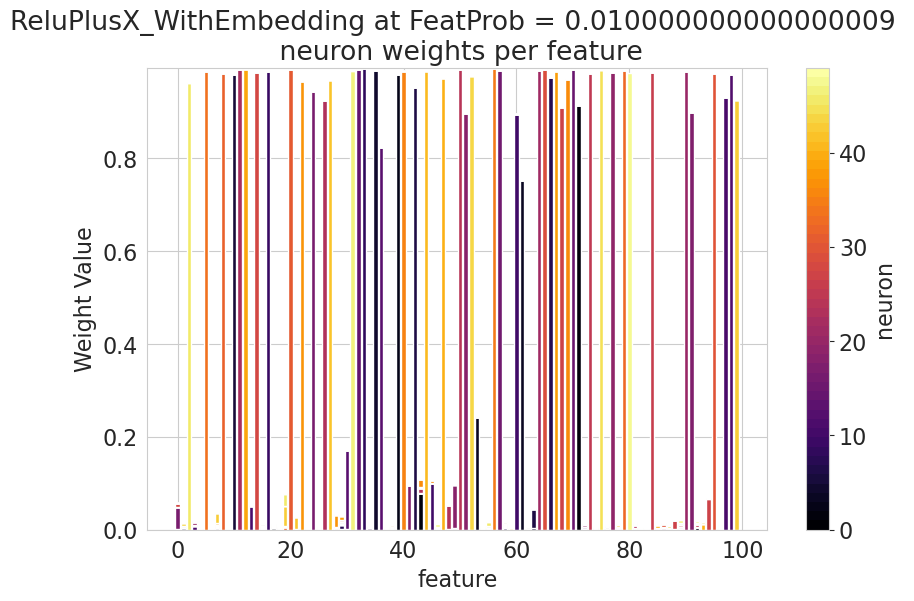

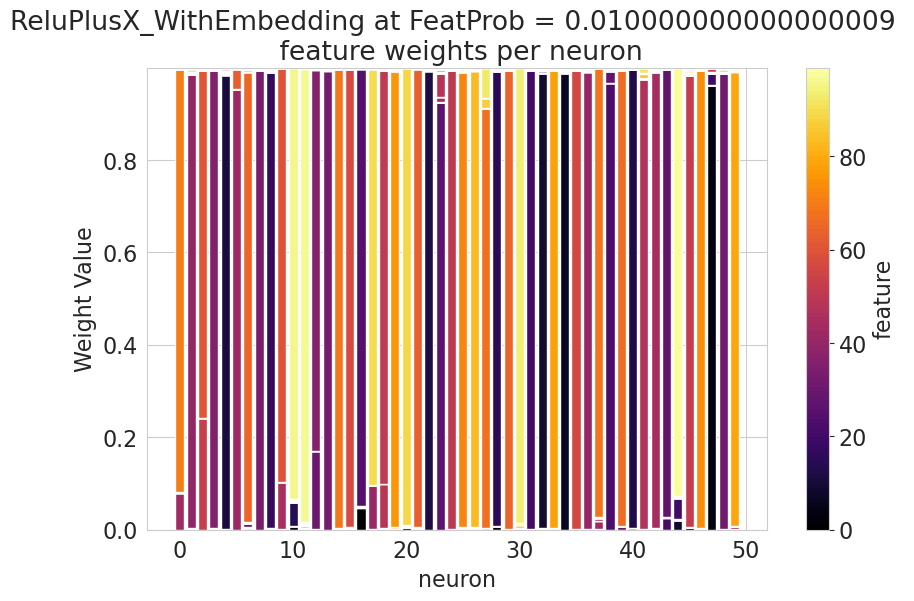

In [8]:
"""Extract and plot weights."""

if model.cfg.We_and_Wu == True: 
    W_feat_to_neuron = einsum(model.We, model.W1,
                          "inst emb feat, inst neuron emb -> neuron feat")
    W_neuron_to_feat = einsum(model.W2, model.Wu,
                          "inst emb neuron, inst feat emb -> feat neuron")
    W = einsum(W_feat_to_neuron, W_neuron_to_feat, "neuron feat, feat neuron -> feat neuron")
else:
    W = einsum(model.W1, model.W2, 
               "inst neuron feature, inst feature neuron-> neuron feature")
    
W = threshold_matrix(W.squeeze(), threshold=0.001)

print(f"{W.shape=}")

fig = plot_weight_bars(W.T, xax="feature", model_name=model.cfg.name, feat_prob=feat_prob)
filename = f"/workspace/{model.cfg.name}_S{feat_prob:.2f}_weights_per_feature.png" 
plt.savefig(filename, dpi=300)
plt.show

fig = plot_weight_bars(W, xax="neuron", model_name=model.cfg.name, feat_prob=feat_prob)
filename = f"/workspace/{model.cfg.name}_S{feat_prob:.2f}_weights_per_neuron.png" 
plt.savefig(filename, dpi=300)
plt.show

In [ ]:
"""Select represented and unrepresented features"""

idx_repr = np.where(np.diag(output-input) > 0.5)[0]
idx_unrepr = np.where(np.diag(output-input) < 0.5)[0]

print("Represented indices (diagonal):", idx_repr)
print("Unrepresented indices (diagonal):", idx_unrepr)

# --- Prepare to sample inputs and store outputs ---
num_samples = 10  # number of samples for each group
n_features = 100

outputs_repr_rep = []    # outputs when only represented features (diagonal ones) are active
outputs_repr_norm_rep = [] 
outputs_repr_unrep = [] 
outputs_repr_norm_unrep = [] 
active_counts_rep = []
active_counts_unrep = []

# For each sample, we create an input vector of zeros,
# then randomly select a subset of either idx_repr or idx_unrepr to activate with a value (e.g., 1).
for k in range(1, len(idx_repr) + 1, 5):
    #if k == 1: 
    #    num_samples = 100
    #else:
    #    num_samples = 10
    num_samples = int(np.ceil(100 / k))
    for _ in range(num_samples):
        # Represented features
        x_repr = t.zeros(n_features, device=device)
        chosen_repr = np.random.choice(idx_repr, size=k, replace=False)
        x_repr[t.tensor(chosen_repr, device=device)] = 1.0  # active value
        with t.no_grad():
            y_repr = model(x_repr.unsqueeze(0).unsqueeze(0))  # shape (1, output_dim)
        norm_y_repr = y_repr - x_repr
        norm_y_repr = norm_y_repr.squeeze(0).squeeze(0)
        active_counts_rep.append([k] * len(idx_repr))
        active_counts_unrep.append([k] * len(idx_unrepr))
        norm_y_np = norm_y_repr.cpu().numpy()
        outputs_repr_norm_rep.append(norm_y_np[idx_repr])
        outputs_repr_norm_unrep.append(norm_y_np[idx_unrepr])

# --- Flatten the results for plotting ---
flat_counts_rep = np.concatenate([np.array(o).flatten() for o in active_counts_rep])
flat_counts_unrep = np.concatenate([np.array(o).flatten() for o in active_counts_unrep])
flat_norm_outputs_repr = np.concatenate([o.flatten() for o in outputs_repr_norm_rep])
flat_norm_outputs_unre = np.concatenate([o.flatten() for o in outputs_repr_norm_unrep])


# --- Plot the outputs vs. number of active features ---
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(15, 10))

ax1.scatter(flat_norm_outputs_repr, flat_counts_rep, alpha=0.7)
sns.kdeplot(x=flat_norm_outputs_repr, y=flat_counts_rep, cmap='magma', fill=False, thresh=0.05, levels=20, 
            bw_adjust=1, label='bw_adjust=0.5', ax=ax1) 
ax1.set_xlabel("Output for represented features")
ax1.set_ylabel("Number of Active Represented Features")

ax2.scatter(flat_norm_outputs_unre, flat_counts_unrep, alpha=0.7)
sns.kdeplot(x=flat_norm_outputs_unre, y=flat_counts_unrep, cmap='magma', fill=False, thresh=0.05, levels=20, 
            bw_adjust=1, label='bw_adjust=0.5', ax=ax2) 
ax2.set_xlabel("Output for Unrepresented features")
ax2.set_ylabel("Number of Active Represented Features")

#plt.title("Model Output vs. Number of Active Represented Features")
filename = f"/workspace/{model.cfg.name}_S{feat_prob:.2f}_RepresentedFeaturesActive_contour.png" 
plt.savefig(filename, dpi=300)
plt.show()

# Now group by the unique active count values.
unique_counts_rep = np.unique(flat_counts_rep)
unique_counts_unrep = np.unique(flat_counts_unrep)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15, 10))
for count in unique_counts_rep:
    # Select outputs corresponding to the current active feature count.
    group_outputs = flat_norm_outputs_repr[flat_counts_rep == count]
    # Plot a histogram (with step outline) for this group.
    ax1.hist(group_outputs, bins=20, histtype="step", linewidth=2, label=f"{int(count)} active features")

ax1.set_xlabel("Model Output")
ax1.set_ylabel("Frequency")
ax1.set_title("Output for represented features")

for count in unique_counts_unrep:
    # Select outputs corresponding to the current active feature count.
    group_outputs = flat_norm_outputs_unre[flat_counts_rep == count]
    # Plot a histogram (with step outline) for this group.
    ax2.hist(group_outputs, bins=20, histtype="step", linewidth=2, label=f"{int(count)} active features")

ax2.set_xlabel("Model Output (Raw)")
ax2.set_ylabel("Frequency")
ax2.set_title("Output for Unrepresented features")

# Remove legends from individual axes.
ax1.legend().remove()
ax2.legend().remove()

# Create a combined legend for the entire figure.
# We can combine handles and labels from one of the axes (assuming they are consistent).
handles, labels = ax2.get_legend_handles_labels()
fig.legend(handles, labels, loc='center left', 
           bbox_to_anchor=(0.98, 0.5), title="Active Represented Features")

# Adjust layout to account for the legend outside.
plt.tight_layout(rect=[0, 0, 0.9, 1])

filename = f"/workspace/{model.cfg.name}_S{feat_prob:.2f}_RepresentedFeaturesActive_hist.png" 
plt.savefig(filename, dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()

active_counts_rep = []
active_counts_unrep = []
outputs_unrepr_rep = []  # outputs when only unrepresented features (diagonal ones) are active  
outputs_unrepr_norm_rep = [] 
outputs_unrepr_unrep = []  # outputs when only unrepresented features (diagonal ones) are active  
outputs_unrepr_norm_unrep = [] 
# For each sample, we create an input vector of zeros,
# then randomly select a subset of either idx_repr or idx_unrepr to activate with a value (e.g., 1).
for k in range(1, len(idx_unrepr) + 1, 5):
    #if k == 1: 
    #    num_samples = 100
    #else:
    #    num_samples = 10
    num_samples = int(np.ceil(100 / k))
    for _ in range(num_samples):
        # Represented features
        x_unrepr = t.zeros(n_features, device=device)
        chosen_unrepr = np.random.choice(idx_unrepr, size=k, replace=False)
        x_unrepr[t.tensor(chosen_unrepr, device=device)] = 1.0  # active value
        with t.no_grad():
            y_unrepr = model(x_unrepr.unsqueeze(0).unsqueeze(0))  # shape (1, output_dim)
        norm_y_repr = y_unrepr - x_unrepr
        norm_y_repr = norm_y_repr.squeeze(0).squeeze(0)
        active_counts_rep.append([k] * len(idx_repr))
        active_counts_unrep.append([k] * len(idx_unrepr))
        norm_y_np = norm_y_repr.cpu().numpy()
        outputs_unrepr_norm_rep.append(norm_y_np[idx_repr])
        outputs_unrepr_norm_unrep.append(norm_y_np[idx_unrepr])
        
# --- Flatten the results for plotting ---
flat_counts_rep = np.concatenate([np.array(o).flatten() for o in active_counts_rep])
flat_counts_unrep = np.concatenate([np.array(o).flatten() for o in active_counts_unrep])
flat_norm_outputs_un = np.concatenate([o.flatten() for o in outputs_unrepr_norm_unrep])
flat_norm_outputs_re = np.concatenate([o.flatten() for o in outputs_unrepr_norm_rep])

# --- Plot the outputs vs. number of active features ---
# --- Plot the outputs vs. number of active features ---
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(15, 10))

ax1.scatter(flat_norm_outputs_re, flat_counts_rep, alpha=0.7)
sns.kdeplot(x=flat_norm_outputs_re, y=flat_counts_rep, cmap='magma', fill=False, thresh=0.05, levels=20, 
            bw_adjust=1, label='bw_adjust=0.5', ax=ax1) 
ax1.set_xlabel("Output for represented features")
ax1.set_ylabel("Number of Active Unrepresented Features")

ax2.scatter(flat_norm_outputs_un, flat_counts_unrep, alpha=0.7)
sns.kdeplot(x=flat_norm_outputs_un, y=flat_counts_unrep, cmap='magma', fill=False, thresh=0.05, levels=20, 
            bw_adjust=1, label='bw_adjust=0.5', ax=ax2) 
ax2.set_xlabel("Output for Unrepresented features")
ax2.set_ylabel("Number of Active Unrepresented Features")

#plt.title("Model Output vs. Number of Active Unepresented Features")
filename = f"/workspace/{model.cfg.name}_S{feat_prob:.2f}_UnrepresentedFeaturesActive_contour.png" 
plt.savefig(filename, dpi=300)
plt.show()

# Now group by the unique active count values.
unique_counts_rep = np.unique(flat_counts_rep)
unique_counts_unrep = np.unique(flat_counts_unrep)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15, 10))
for count in unique_counts_rep:
    # Select outputs corresponding to the current active feature count.
    group_outputs = flat_norm_outputs_re[flat_counts_rep == count]
    # Plot a histogram (with step outline) for this group.
    ax1.hist(group_outputs, bins=20, histtype="step", linewidth=2, label=f"{int(count)} active features")

ax1.set_xlabel("Model Output")
ax1.set_ylabel("Frequency")
ax1.set_title("Output for represented features")

for count in unique_counts_unrep:
    # Select outputs corresponding to the current active feature count.
    group_outputs = flat_norm_outputs_unre[flat_counts_rep == count]
    # Plot a histogram (with step outline) for this group.
    ax2.hist(group_outputs, bins=20, histtype="step", linewidth=2, label=f"{int(count)} active features")

ax2.set_xlabel("Model Output")
ax2.set_ylabel("Frequency")
ax2.set_title("Output for Unrepresented features")

# Remove legends from individual axes.
ax1.legend().remove()
ax2.legend().remove()

# Create a combined legend for the entire figure.
# We can combine handles and labels from one of the axes (assuming they are consistent).
handles, labels = ax2.get_legend_handles_labels()
fig.legend(handles, labels, loc='center left', 
           bbox_to_anchor=(0.98, 0.5), title="Active Unrepresented Features")

# Adjust layout to account for the legend outside.
plt.tight_layout(rect=[0, 0, 0.9, 1])

filename = f"/workspace/{model.cfg.name}_S{feat_prob:.2f}_UnrepresentedFeaturesActive_hist.png" 
plt.savefig(filename, dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()

In [ ]:
# After training, change unembedding matrix by pseudoinverse

print(model.Wu)
with t.no_grad():
    model.Wu.copy_(t.linalg.pinv(model.We))
print(model.Wu)


In [ ]:
"""Plot spectrum output plots"""

vals = t.linspace(-1, 1, 100, device=device)  # input values
active_feat_value_idx = 99

n_feat, n_vals = model.cfg.n_feat, len(vals)
# input `X` will be: active_feature_idx X values X full_feature_vector
X = t.zeros(n_feat, n_vals, n_feat, device=device)
feat_idx = t.arange(n_feat, device=device).unsqueeze(1).expand(n_feat, n_vals)
val_idx = t.arange(n_vals, device=device).unsqueeze(0).expand(n_feat, n_vals)
X[feat_idx, val_idx, feat_idx] = vals.unsqueeze(0).expand(n_feat, n_vals)
# reshape for batch input
X = rearrange(X, "active_feat val feat_vec -> (active_feat val) 1 feat_vec")
Y = model.forward(X)
    # reshape for plotting by feature
Y = rearrange(
   Y, 
   "(active_feat val) 1 feat_vec -> active_feat val feat_vec",
    active_feat=n_feat, 
   val=n_vals
)
X = rearrange(X, 
   "(active_feat val) 1 feat_vec -> active_feat val feat_vec",
    active_feat=n_feat, 
   val=n_vals)
print("X.shape = ", X.shape)
print("Y.shape = ", Y.shape)
output= Y[:,active_feat_value_idx,:].cpu().detach().numpy()
input = X[:,active_feat_value_idx,:].cpu().detach().numpy()

fig,axs = plt.subplots(1, 2, figsize=(15, 7))
im0 = axs[0].imshow(output-input, aspect='auto', cmap='viridis')
fig.colorbar(im0, ax=axs[0])
axs[0].set_title("Output")
axs[0].set_xlabel("Features")
axs[0].set_ylabel("Active feature")

im1 = axs[1].imshow(input, aspect='auto', cmap='viridis')
fig.colorbar(im1, ax=axs[1])
axs[1].set_title("Input")
axs[1].set_xlabel("Features")
axs[1].set_ylabel("Active feature")
#fig.title(f"{model.cfg.name} trained at featProb = {feat_prob:.2f}:\n output heatmap")
plt.tight_layout()
filename = f"/workspace/{model.cfg.name}_S{feat_prob:.2f}_output_heatmap.png" 
plt.savefig(filename, dpi=300)
plt.show()

print(Y[:,active_feat_value_idx,:].cpu().detach().numpy())

In [ ]:
"""Compute and plot the model's performance across sparsities."""

sparsity_low = np.round(np.linspace(0.0,0.8,9),2)
sparsity_high = np.round(np.linspace(0.8,0.99,20),2)
sparsities = np.unique(np.concatenate((sparsity_low,sparsity_high)))
batch_sz = 256
feat_importance = 1

loss_data = performance_across_sparsities(sparsities, model)

"""Plot performance across different input sparsities"""
fig = plot_loss_across_sparsities(loss_data, sparsities, model.cfg.name, feat_sparsity)

# save figure and show
filename = f"/workspace/{model.cfg.name}_S{feat_prob:.2f}_loss_plot.png" 
plt.savefig(filename, dpi=300)
plt.show()

In [ ]:
"""Compute and plot input-output response profile."""

vals = t.linspace(-1, 1, 100, device=device)  # input values
Y = in_out_response(model, vals, device)
print(Y.shape)
fig = plot_input_output_response(Y, vals, model.cfg.name, feat_prob, losses)

# save figure and show
filename = f"/workspace/{model.cfg.name}_S{feat_prob:.2f}_input_output_response.png" 
plt.savefig(filename, dpi=300)
plt.show()

In [ ]:
"""Select represented and unrepresented features"""

idx_repr = np.where(np.diag(output-input) > 0.5)[0]
idx_unrepr = np.where(np.diag(output-input) < 0.5)[0]

print("Represented indices (diagonal):", idx_repr)
print("Unrepresented indices (diagonal):", idx_unrepr)

# --- Prepare to sample inputs and store outputs ---
num_samples = 10  # number of samples for each group
n_features = 100

outputs_repr_rep = []    # outputs when only represented features (diagonal ones) are active
outputs_repr_norm_rep = [] 
outputs_repr_unrep = [] 
outputs_repr_norm_unrep = [] 
active_counts_rep = []
active_counts_unrep = []

# For each sample, we create an input vector of zeros,
# then randomly select a subset of either idx_repr or idx_unrepr to activate with a value (e.g., 1).
for k in range(1, len(idx_repr) + 1, 5):
    #if k == 1: 
    #    num_samples = 100
    #else:
    #    num_samples = 10
    num_samples = int(np.ceil(100 / k))
    for _ in range(num_samples):
        # Represented features
        x_repr = t.zeros(n_features, device=device)
        chosen_repr = np.random.choice(idx_repr, size=k, replace=False)
        x_repr[t.tensor(chosen_repr, device=device)] = 1.0  # active value
        with t.no_grad():
            y_repr = model(x_repr.unsqueeze(0).unsqueeze(0))  # shape (1, output_dim)
        norm_y_repr = y_repr - x_repr
        norm_y_repr = norm_y_repr.squeeze(0).squeeze(0)
        active_counts_rep.append([k] * len(idx_repr))
        active_counts_unrep.append([k] * len(idx_unrepr))
        norm_y_np = norm_y_repr.cpu().numpy()
        outputs_repr_norm_rep.append(norm_y_np[idx_repr])
        outputs_repr_norm_unrep.append(norm_y_np[idx_unrepr])

# --- Flatten the results for plotting ---
flat_counts_rep = np.concatenate([np.array(o).flatten() for o in active_counts_rep])
flat_counts_unrep = np.concatenate([np.array(o).flatten() for o in active_counts_unrep])
flat_norm_outputs_repr = np.concatenate([o.flatten() for o in outputs_repr_norm_rep])
flat_norm_outputs_unre = np.concatenate([o.flatten() for o in outputs_repr_norm_unrep])


# --- Plot the outputs vs. number of active features ---
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(15, 10))

ax1.scatter(flat_norm_outputs_repr, flat_counts_rep, alpha=0.7)
sns.kdeplot(x=flat_norm_outputs_repr, y=flat_counts_rep, cmap='magma', fill=False, thresh=0.05, levels=20, 
            bw_adjust=1, label='bw_adjust=0.5', ax=ax1) 
ax1.set_xlabel("Output for represented features")
ax1.set_ylabel("Number of Active Represented Features")

ax2.scatter(flat_norm_outputs_unre, flat_counts_unrep, alpha=0.7)
sns.kdeplot(x=flat_norm_outputs_unre, y=flat_counts_unrep, cmap='magma', fill=False, thresh=0.05, levels=20, 
            bw_adjust=1, label='bw_adjust=0.5', ax=ax2) 
ax2.set_xlabel("Output for Unrepresented features")
ax2.set_ylabel("Number of Active Represented Features")

#plt.title("Model Output vs. Number of Active Represented Features")
filename = f"/workspace/{model.cfg.name}_S{feat_prob:.2f}_RepresentedFeaturesActive_contour.png" 
plt.savefig(filename, dpi=300)
plt.show()

# Now group by the unique active count values.
unique_counts_rep = np.unique(flat_counts_rep)
unique_counts_unrep = np.unique(flat_counts_unrep)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15, 10))
for count in unique_counts_rep:
    # Select outputs corresponding to the current active feature count.
    group_outputs = flat_norm_outputs_repr[flat_counts_rep == count]
    # Plot a histogram (with step outline) for this group.
    ax1.hist(group_outputs, bins=20, histtype="step", linewidth=2, label=f"{int(count)} active features")

ax1.set_xlabel("Model Output")
ax1.set_ylabel("Frequency")
ax1.set_title("Output for represented features")

for count in unique_counts_unrep:
    # Select outputs corresponding to the current active feature count.
    group_outputs = flat_norm_outputs_unre[flat_counts_rep == count]
    # Plot a histogram (with step outline) for this group.
    ax2.hist(group_outputs, bins=20, histtype="step", linewidth=2, label=f"{int(count)} active features")

ax2.set_xlabel("Model Output (Raw)")
ax2.set_ylabel("Frequency")
ax2.set_title("Output for Unrepresented features")

# Remove legends from individual axes.
ax1.legend().remove()
ax2.legend().remove()

# Create a combined legend for the entire figure.
# We can combine handles and labels from one of the axes (assuming they are consistent).
handles, labels = ax2.get_legend_handles_labels()
fig.legend(handles, labels, loc='center left', 
           bbox_to_anchor=(0.98, 0.5), title="Active Represented Features")

# Adjust layout to account for the legend outside.
plt.tight_layout(rect=[0, 0, 0.9, 1])

filename = f"/workspace/{model.cfg.name}_S{feat_prob:.2f}_RepresentedFeaturesActive_hist.png" 
plt.savefig(filename, dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()

active_counts_rep = []
active_counts_unrep = []
outputs_unrepr_rep = []  # outputs when only unrepresented features (diagonal ones) are active  
outputs_unrepr_norm_rep = [] 
outputs_unrepr_unrep = []  # outputs when only unrepresented features (diagonal ones) are active  
outputs_unrepr_norm_unrep = [] 
# For each sample, we create an input vector of zeros,
# then randomly select a subset of either idx_repr or idx_unrepr to activate with a value (e.g., 1).
for k in range(1, len(idx_unrepr) + 1, 5):
    #if k == 1: 
    #    num_samples = 100
    #else:
    #    num_samples = 10
    num_samples = int(np.ceil(100 / k))
    for _ in range(num_samples):
        # Represented features
        x_unrepr = t.zeros(n_features, device=device)
        chosen_unrepr = np.random.choice(idx_unrepr, size=k, replace=False)
        x_unrepr[t.tensor(chosen_unrepr, device=device)] = 1.0  # active value
        with t.no_grad():
            y_unrepr = model(x_unrepr.unsqueeze(0).unsqueeze(0))  # shape (1, output_dim)
        norm_y_repr = y_unrepr - x_unrepr
        norm_y_repr = norm_y_repr.squeeze(0).squeeze(0)
        active_counts_rep.append([k] * len(idx_repr))
        active_counts_unrep.append([k] * len(idx_unrepr))
        norm_y_np = norm_y_repr.cpu().numpy()
        outputs_unrepr_norm_rep.append(norm_y_np[idx_repr])
        outputs_unrepr_norm_unrep.append(norm_y_np[idx_unrepr])
        
# --- Flatten the results for plotting ---
flat_counts_rep = np.concatenate([np.array(o).flatten() for o in active_counts_rep])
flat_counts_unrep = np.concatenate([np.array(o).flatten() for o in active_counts_unrep])
flat_norm_outputs_un = np.concatenate([o.flatten() for o in outputs_unrepr_norm_unrep])
flat_norm_outputs_re = np.concatenate([o.flatten() for o in outputs_unrepr_norm_rep])

# --- Plot the outputs vs. number of active features ---
# --- Plot the outputs vs. number of active features ---
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(15, 10))

ax1.scatter(flat_norm_outputs_re, flat_counts_rep, alpha=0.7)
sns.kdeplot(x=flat_norm_outputs_re, y=flat_counts_rep, cmap='magma', fill=False, thresh=0.05, levels=20, 
            bw_adjust=1, label='bw_adjust=0.5', ax=ax1) 
ax1.set_xlabel("Output for represented features")
ax1.set_ylabel("Number of Active Unrepresented Features")

ax2.scatter(flat_norm_outputs_un, flat_counts_unrep, alpha=0.7)
sns.kdeplot(x=flat_norm_outputs_un, y=flat_counts_unrep, cmap='magma', fill=False, thresh=0.05, levels=20, 
            bw_adjust=1, label='bw_adjust=0.5', ax=ax2) 
ax2.set_xlabel("Output for Unrepresented features")
ax2.set_ylabel("Number of Active Unrepresented Features")

#plt.title("Model Output vs. Number of Active Unepresented Features")
filename = f"/workspace/{model.cfg.name}_S{feat_prob:.2f}_UnrepresentedFeaturesActive_contour.png" 
plt.savefig(filename, dpi=300)
plt.show()

# Now group by the unique active count values.
unique_counts_rep = np.unique(flat_counts_rep)
unique_counts_unrep = np.unique(flat_counts_unrep)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15, 10))
for count in unique_counts_rep:
    # Select outputs corresponding to the current active feature count.
    group_outputs = flat_norm_outputs_re[flat_counts_rep == count]
    # Plot a histogram (with step outline) for this group.
    ax1.hist(group_outputs, bins=20, histtype="step", linewidth=2, label=f"{int(count)} active features")

ax1.set_xlabel("Model Output")
ax1.set_ylabel("Frequency")
ax1.set_title("Output for represented features")

for count in unique_counts_unrep:
    # Select outputs corresponding to the current active feature count.
    group_outputs = flat_norm_outputs_unre[flat_counts_rep == count]
    # Plot a histogram (with step outline) for this group.
    ax2.hist(group_outputs, bins=20, histtype="step", linewidth=2, label=f"{int(count)} active features")

ax2.set_xlabel("Model Output")
ax2.set_ylabel("Frequency")
ax2.set_title("Output for Unrepresented features")

# Remove legends from individual axes.
ax1.legend().remove()
ax2.legend().remove()

# Create a combined legend for the entire figure.
# We can combine handles and labels from one of the axes (assuming they are consistent).
handles, labels = ax2.get_legend_handles_labels()
fig.legend(handles, labels, loc='center left', 
           bbox_to_anchor=(0.98, 0.5), title="Active Unrepresented Features")

# Adjust layout to account for the legend outside.
plt.tight_layout(rect=[0, 0, 0.9, 1])

filename = f"/workspace/{model.cfg.name}_S{feat_prob:.2f}_UnrepresentedFeaturesActive_hist.png" 
plt.savefig(filename, dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()